In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots
import pickle
import scipy

from utils import utils
import utils.efinet as efinet
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
# import cuml

# Plot settings
fpath = "C:/Users/Marek/OneDrive/School/DP/masters-thesis/assets/figures/clas"
# plt.rcParams["font.family"] = ["Latin Modern Roman"]
plt.rcParams["figure.figsize"] = (5, 5)
plt.style.use("science")
# plt.rcParams["savefig.dpi"] = 300
# plt.rcParams["font.size"] = 20

In [35]:
# Load labels
with open("../data/Merged/CLAS_merged_5s.pkl", "rb") as f:
    labels = pickle.load(f)
labels = labels["label"]
labels[labels == 1] = 10
labels[labels == 3] = 1
labels[labels == 6] = 1
labels[labels == 8] = 1
idx = labels.isin([0, 1])
labels = labels[idx]

# Load and concat data
with open("../data/GADF_Data/GADF_CLAS_merged_5s.pkl", "rb") as f:
    gadf = pickle.load(f)

gcn = scipy.io.loadmat("../data/GCN_Data//GCN_CLAS_Standard_5s.mat")
gcn = np.transpose(gcn["cause5s"], (0, 2, 3, 1))

L = len(gcn)

result = []
for i in range(L):
    result.append(gcn[i] + gadf[i])

data = np.array(result)[idx]

print("Data shape: ", np.shape(data))
print("Counts: \n", pd.value_counts(labels))

Data shape:  (7602, 32, 32, 3)
Counts: 
 1    6964
0     638
Name: label, dtype: int64


In [36]:
# Split data into train and test
X, y = data, labels.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

(5093, 32, 32, 3) (2509, 32, 32, 3) (5093,) (2509,)


In [43]:
model_name = "CLAS_5s"
lr = 5e-4
epochs = 100
batch_size = 256

# Train model
train_model, eval_model = efinet.build_graph([32, 32, 3], 2)
trained_model = efinet.train(model=train_model, data=((X_train, y_train), (X_test, y_test)),
                             epochs=epochs, lr=lr, model_name=model_name, batch_size=batch_size)







Epoch 1/100
17/20 [========================>.....] - ETA: 0s - loss: 0.3705 - Efficient_CapsNet_loss: 0.1591 - Generator_loss: 0.5392 - Efficient_CapsNet_accuracy: 0.8927
Epoch 1: val_Efficient_CapsNet_accuracy improved from -inf to 0.91351, saving model to ../results\models
20/20 [==============================] - 2s 37ms/step - loss: 0.3519 - Efficient_CapsNet_loss: 0.1476 - Generator_loss: 0.5211 - Efficient_CapsNet_accuracy: 0.8944 - val_loss: 0.2406 - val_Efficient_CapsNet_loss: 0.0771 - val_Generator_loss: 0.4173 - val_Efficient_CapsNet_accuracy: 0.9135 - lr: 5.0000e-04
Epoch 2/100
17/20 [========================>.....] - ETA: 0s - loss: 0.2279 - Efficient_CapsNet_loss: 0.0676 - Generator_loss: 0.4088 - Efficient_CapsNet_accuracy: 0.9191
Epoch 2: val_Efficient_CapsNet_accuracy did not improve from 0.91351
20/20 [==============================] - 0s 19ms/step - loss: 0.2292 - Efficient_CapsNet_loss: 0.0690 - Generator_loss: 0.4087 - Efficient_CapsNet_accuracy: 0.9173 - val_l

In [44]:
print("Train acc: ", np.round(np.max(trained_model.history.history["Efficient_CapsNet_accuracy"]), 4))
print("Val acc: ", np.round(np.max(trained_model.history.history["val_Efficient_CapsNet_accuracy"]), 4))

Train acc:  0.9935
Val acc:  0.9179


Accuracy = 0.9166998804304504
F1 Score = 0.5550199119681408
TPR = 0.776731208820761
TNR =  0.5413791508834576
AUC = 0.6923943027641728


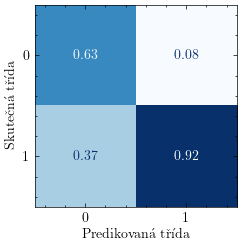

In [45]:
eval_model.load_weights(f"../results/models/CLAS_5s.h5")

# Predict the values from the validation dataset
Y_pred = eval_model.predict(X_test)

utils.print_stats(y_test, Y_pred)
utils.plot_confusion_matrix(y_test, Y_pred, normalize="pred")
plt.savefig(f"{fpath}/clas_5s.pdf", format="pdf", bbox_inches="tight")

In [47]:
# sm = SMOTETomek(random_state=42, smote=SMOTE(k_neighbors=cuml.NearestNeighbors(n_neighbors=5)))
# X_res, y_res = sm.fit_resample(X.reshape(len(X), -1), y)
# X_res = X_res.reshape(-1, 32, 32, 3)
#
# with open("../data/augmented_cuml/CLAS_5s50_AUG.pkl", "wb") as f:
#     pickle.dump({"X": X_res, "y": y_res}, f)

with open("../data/augmented_cuml/CLAS_5s_AUG.pkl", "rb") as f:
    data = pickle.load(f)
    X_res, y_res = data["X"], data["y"]

print(X_res.shape, y_res.shape)
print("Label counts: \n", pd.value_counts(y_res))

X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.20, random_state=42)
print(X_train_res.shape, X_test_res.shape, y_train_res.shape, y_test_res.shape)

y_train_res = to_categorical(y_train_res, num_classes=2)
y_test_res = to_categorical(y_test_res, num_classes=2)

(13926, 32, 32, 3) (13926,)
Label counts: 
 0    6963
1    6963
dtype: int64
(11140, 32, 32, 3) (2786, 32, 32, 3) (11140,) (2786,)


In [48]:
model_name = "CLAS_5s_AUG"
lr = 5e-4
epochs = 100
batch_size = 256

# Train model
train_model_aug, eval_model_aug = efinet.build_graph([32, 32, 3], 2)
trained_model_aug = efinet.train(model=train_model_aug, data=((X_train_res, y_train_res), (X_test_res, y_test_res)),
                                 epochs=epochs, lr=lr, model_name=model_name, batch_size=batch_size)







Epoch 1/100
44/44 [==============================] - ETA: 0s - loss: 0.3298 - Efficient_CapsNet_loss: 0.1664 - Generator_loss: 0.4170 - Efficient_CapsNet_accuracy: 0.7959
Epoch 1: val_Efficient_CapsNet_accuracy improved from -inf to 0.50287, saving model to ../results\models
44/44 [==============================] - 2s 31ms/step - loss: 0.3298 - Efficient_CapsNet_loss: 0.1664 - Generator_loss: 0.4170 - Efficient_CapsNet_accuracy: 0.7959 - val_loss: 0.4767 - val_Efficient_CapsNet_loss: 0.3339 - val_Generator_loss: 0.3645 - val_Efficient_CapsNet_accuracy: 0.5029 - lr: 5.0000e-04
Epoch 2/100
44/44 [==============================] - ETA: 0s - loss: 0.2213 - Efficient_CapsNet_loss: 0.0784 - Generator_loss: 0.3644 - Efficient_CapsNet_accuracy: 0.8893
Epoch 2: val_Efficient_CapsNet_accuracy improved from 0.50287 to 0.56425, saving model to ../results\models
44/44 [==============================] - 1s 20ms/step - loss: 0.2213 - Efficient_CapsNet_loss: 0.0784 - Generator_loss: 0.3644 - Eff

In [49]:
print("Train acc: ", np.round(np.max(trained_model_aug.history.history["Efficient_CapsNet_accuracy"]), 4))
print("Val acc: ", np.round(np.max(trained_model_aug.history.history["val_Efficient_CapsNet_accuracy"]), 4))

Train acc:  0.9991
Val acc:  0.9745


Accuracy = 0.9716439339554918
F1 Score = 0.9716399549680202
TPR = 0.9721374604903732
TNR =  0.971744009565112
AUC = 0.9939944907840456


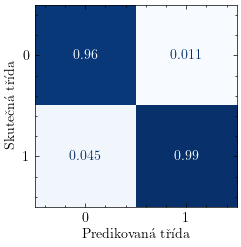

In [50]:
eval_model_aug.load_weights(f"../results/models/CLAS_5s_AUG.h5")

# Predict the values from the validation dataset
Y_pred_aug = eval_model_aug.predict(X_test_res)

utils.print_stats(y_test_res, Y_pred_aug)
utils.plot_confusion_matrix(y_test_res, Y_pred_aug)
plt.savefig(f"{fpath}/clas_5s_aug.pdf", format="pdf", bbox_inches="tight")